# TELCO Churn Report

### Goals
- Identify Drivers of Churn
- Build a Model that accurately predicts churn better than the baseline (of predicting no churn)

### Initial Hypotheses
- Contract status, Internet subscription status, partner status, payment type are all drivers of change.

In [1]:
# ignore warnings
import warnings
warnings.filterwarnings("ignore")

#import relevant libraries
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.model_selection import train_test_split
from env import host, user, password

import wrangle

In [2]:
# import raw telco data
raw_telco = wrangle.new_telco_data()

In [3]:
# Columns to drop: customer_id (can be added back later for predection), payment_type_id, 
# internet_service_type_id, contract_type_id, multiple_lines, online_security, online_backup, 
# device_protection, tech_support, streaming_tv, streaming_movies, paperless_billing

# Pass to prepare function which will return our train, validate, test data sets

wrangled_telco, train, validate, test = wrangle.clean_prep_telco(raw_telco)

In [4]:
# Contracts impact length of tenure.
# First start basic and verify mathematically that contract type is not independent of tenure
# Null Hypothesis - Contract type is independent of Churn

telco_contract_churn_observed = pd.crosstab(wrangled_telco.churn, wrangled_telco.contract_type_no_contract)

In [5]:
chi2, p, degf, expected = stats.chi2_contingency(telco_contract_churn_observed)

print('Observed\n')
print(telco_contract_churn_observed.values)
print('---\nExpected\n')
print(expected)
print('---\n')
print(f'chi^2 = {chi2:.4f}')
print(f'p     = {p:.4f}')

Observed

[[2954 2220]
 [ 214 1655]]
---
Expected

[[2327.30824933 2846.69175067]
 [ 840.69175067 1028.30824933]]
---

chi^2 = 1153.9717
p     = 0.0000


## Observed

[[2954 2220]
 [ 214 1655]]
---
## Expected

[[2327.30824933 2846.69175067]
 [ 840.69175067 1028.30824933]]
---

- chi^2 = 1153.9717
- p     = 0.0000

### With this low a P-value, that means we can reject our null hypothesis that contract type and churn are independent.

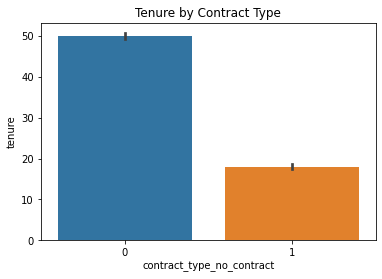

In [6]:
# p value of 0.0000, we reject our null hypothesis that they are independent

# Help visualize this by looking at average tenure length between contract types
plt.title("Tenure by Contract Type")
sns.barplot(x="contract_type_no_contract", y="tenure", data=wrangled_telco)
plt.show()

In [7]:
# Does payment type (manual vs. automatic) status impact length of tenure.
# Verify mathematically that whether or not customer has a partner is not independent of tenure
# Null Hypothesis - Payment type is independent of Churn

telco_payment_churn_observed = pd.crosstab(wrangled_telco.churn, wrangled_telco.payment_type_manual_payment)
telco_payment_churn_observed

payment_type_manual_payment,0,1
churn,,
No,2576,2598
Yes,490,1379


In [8]:
chi2, p, degf, expected = stats.chi2_contingency(telco_payment_churn_observed)

print('Observed\n')
print(telco_payment_churn_observed.values)
print('---\nExpected\n')
print(expected)
print('---\n')
print(f'chi^2 = {chi2:.4f}')
print(f'p     = {p:.4f}')

Observed

[[2576 2598]
 [ 490 1379]]
---
Expected

[[2252.37597615 2921.62402385]
 [ 813.62402385 1055.37597615]]
---

chi^2 = 309.3486
p     = 0.0000


## Observed

[[2576 2598]
 [ 490 1379]]
---
## Expected

[[2252.37597615 2921.62402385]
 [ 813.62402385 1055.37597615]]
---

- chi^2 = 309.3486
- p     = 0.0000

### With this low a P-value, that means we can reject our null hypothesis that contract type and churn are independent.

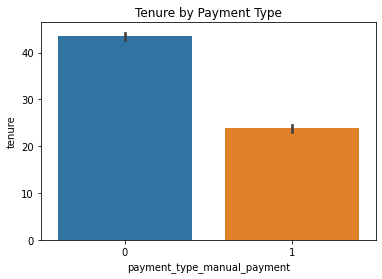

In [9]:
# p value of 0.0000, we reject our null hypothesis that they are independent

# Help visualize this by looking at average tenure length by payment type (automatic vs. manual)
plt.title("Tenure by Payment Type")
sns.barplot(x="payment_type_manual_payment", y="tenure", data=wrangled_telco)
plt.show()

In [10]:
# cols_to_drop = ['churn', 'baseline_prediction', 'total_charges', 'monthly_charges', 'internet_service_type_Fiber optic', 'internet_service_type_None']

cols_to_drop = ['churn', 'total_charges', 'monthly_charges']

X_train = train.drop(columns=cols_to_drop)
y_train = train.churn

X_validate = validate.drop(columns=cols_to_drop)
y_validate = validate.churn

X_test = test.drop(columns=cols_to_drop)
y_test = test.churn

In [11]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

In [12]:
# from sklearn.linear_model import LogisticRegression
logit = LogisticRegression(C=1, random_state=123, intercept_scaling=1, solver='saga')

In [13]:
logit.fit(X_train, y_train)

LogisticRegression(C=1, random_state=123, solver='saga')

In [14]:
print('Accuracy of Logistic Regression classifier on training set: {:.2f}'
     .format(logit.score(X_train, y_train)))

Accuracy of Logistic Regression classifier on training set: 0.80


In [15]:
y_pred = logit.predict(X_train)

In [16]:
print(classification_report(y_train, y_pred))

              precision    recall  f1-score   support

          No       0.84      0.90      0.87      2897
         Yes       0.64      0.52      0.58      1046

    accuracy                           0.80      3943
   macro avg       0.74      0.71      0.72      3943
weighted avg       0.79      0.80      0.79      3943



### Our model's classification report:
              precision    recall  f1-score   support

          No       0.84      0.90      0.87      2897
         Yes       0.64      0.52      0.58      1046

    accuracy                           0.80      3943

In [17]:
print('Accuracy of random forest classifier on validate set: {:.2f}'
     .format(logit.score(X_validate, y_validate)))

Accuracy of random forest classifier on validate set: 0.80


In [18]:
print('Accuracy of random forest classifier on test set: {:.2f}'
     .format(logit.score(X_test, y_test)))

Accuracy of random forest classifier on test set: 0.80


# Models
### Tested a variety of models (Decision Tree, Random Tree, KNN, and Logistic Regression.
### Only Logistic Regression model performed well on the validation sets compared to the train sets

## Logistic Model Accuracy steady at 80% on Validate & Test sets (7% above baseline)

# Conclusion

### Hypotheses Answer
- None of the items are independent, however internet subscription status is far less notable compared to contract, payment method, and partner status.

### Key Findings
- Payment type is a significant driver of churn

### Recommendations
- Automatic payments should be incentivized to reduce churn

### Takeaways
- Further explore extent to which automatic payment can be used to reduce churn
- Explore extent to which we can further incentivize contracts